# Acquire and harmonise datasets

To make our long-term, upscaled GPP predictions we need climate and ancillary datasets harmonised to the target 5km grids.

Require:
* ANUClim: rainfall, radiation, temp, VPD
* VegH
* NDVI from AusENDVI

In [ ]:
import os
import pickle
import xarray as xr
import pandas as pd
import numpy as np
from odc.geo.xr import assign_crs

import sys
sys.path.append('/g/data/xc0/project/AusEFlux/src/')
from _utils import round_coords

In [ ]:
def _vegetation_fractions(results,
                          target_grid='5km',
                          ndvi_max=0.91,
                          dask_chunks=dict(latitude=1500, longitude=1500, time=-1)
):
    """
    Calculate per-pixel fraction of trees, grass, bare using the methods defined by
    Donohue et al. (2009).

    Requires NDVI (not any other vegetation index).

    `ndvi_min` is the minimum NDVI that a pixel can achieve, this was computed
    for Australia and supplied by Dr Luigi Renzullo.
    
    """
    ndvi_path='/g/data/os22/chad_tmp/AusENDVI/data/5km/NDVI_5km_monthly_1982_2022.nc'
    ndvi_min_path =f'/g/data/xc0/project/AusEFlux/data/ndvi_of_baresoil_{target_grid}.nc'
    
    # NDVI value of bare soil (supplied by Luigi Renzullo)
    ndvi_min = xr.open_dataset(ndvi_min_path,
                                chunks=dict(latitude=dask_chunks['latitude'],
                                longitude=dask_chunks['longitude'])
                                )['NDVI']

    ndvi_min.name = 'NDVI'
    
    #ndvi data is here
    ds = xr.open_dataarray(ndvi_path, chunks=dask_chunks)

    #calculate f-total
    ft = (ds - ndvi_min) / (ndvi_max - ndvi_min)
    ft = xr.where(ft<0, 0, ft)
    ft = xr.where(ft>1, 1, ft)
    
    #calculate initial persistent fraction (equation 1 & 2 in Donohue 2009)
    persist = ft.rolling(time=7, min_periods=1).min()
    persist = persist.rolling(time=9, min_periods=1).mean()
    
    #calculate initial recurrent fraction (equation 3 in Donohue 2009)
    recurrent = ft - persist
    
    ###------- equations 4 & 5 in Donohue 2009----------------
    persist = xr.where(recurrent<0, persist - np.abs(recurrent), persist) #eq4
    recurrent = ft - persist # eq 5
    ## ---------------------------------------------------------
    
    #ensure values are between 0 and 1
    persist = xr.where(persist<0, 0, persist)
    recurrent = xr.where(recurrent<0, 0, recurrent)
    
    #assign variable names
    recurrent.name='grass'
    persist.name='trees'
    
    # Aggregate to annual layers
    # Use the maximum fraction of trees and grass to create annual layers.
    # Bare soil is the residual
    persist_annual = persist.resample(time='1Y').max().compute()
    recurrent_annual = recurrent.resample(time='1Y').max().compute()
    bare_annual = 1-(persist_annual+recurrent_annual)
    bare_annual.name='bare'

    #create a monthly timeseries (same value for each month within a year)
    dss_trees=[]
    dss_grass=[]
    dss_bare=[]
    for y in bare_annual.time.dt.year.values:
        # print(y)
        y = str(y)
        time = pd.date_range(y+"-01", y+"-12", freq='MS') 
        time = [t+pd.Timedelta(14, 'd') for t in time]
    
        #trees
        ds_persist = persist_annual.sel(time=y).squeeze().drop('time')
        ds_persist = ds_persist.expand_dims(time=time)
        dss_trees.append(ds_persist)
    
        #grass
        ds_recurrent = recurrent_annual.sel(time=y).squeeze().drop('time')
        ds_recurrent = ds_recurrent.expand_dims(time=time)
        dss_grass.append(ds_recurrent)
    
        ds_bare = bare_annual.sel(time=y).squeeze().drop('time')
        ds_bare = ds_bare.expand_dims(time=time)
        dss_bare.append(ds_bare)
    
    # join all the datasets back together
    trees = xr.concat(dss_trees, dim='time').sortby('time')
    grass = xr.concat(dss_grass, dim='time').sortby('time')
    bare = xr.concat(dss_bare, dim='time').sortby('time')
    
    # add right metadata
    trees.attrs['nodata'] = np.nan
    grass.attrs['nodata'] = np.nan
    bare.attrs['nodata'] = np.nan
    trees = assign_crs(trees, crs='EPSG:4326')
    grass = assign_crs(grass, crs='EPSG:4326')
    bare = assign_crs(bare, crs='EPSG:4326')

    #export
    trees.to_netcdf(f'{results}trees_{target_grid}_monthly_1982_2022.nc')
    grass.to_netcdf(f'{results}grass_{target_grid}_monthly_1982_2022.nc')
    bare.to_netcdf(f'{results}bare_{target_grid}_monthly_1982_2022.nc')

_vegetation_fractions(results='/g/data/os22/chad_tmp/AusENDVI/data/5km/', target_grid='5km')

In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [7]:
ndvi = xr.open_dataset('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/notebooks/upscale_GPP/data/5km/NDVI_5km_monthly_1982_2022.nc')['NDVI']
kndvi = np.tanh(ndvi ** 2)

In [8]:
kndvi.name = 'kNDVI'
kndvi.to_netcdf('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/notebooks/upscale_GPP/data/5km/kNDVI_5km_monthly_1982_2022.nc')

In [9]:
mean = kndvi.groupby("time.month").mean("time")
frac = kndvi.groupby("time.month") / mean
frac = frac.compute().drop_vars('month')
frac.name = 'kNDVI_anom'
frac.to_netcdf('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/notebooks/upscale_GPP/data/5km/kNDVI_anom_5km_monthly_1982_2022.nc')

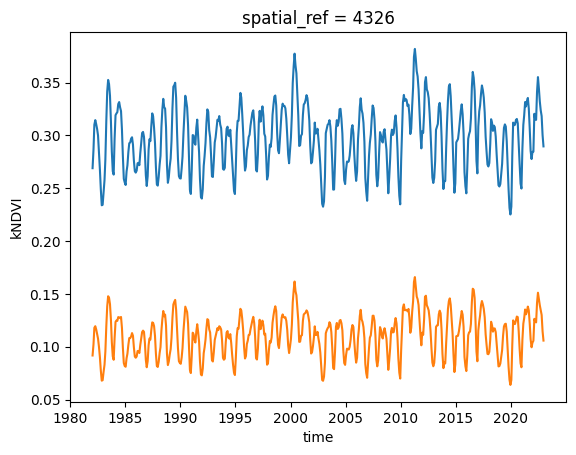

In [12]:
ndvi.mean(['latitude', 'longitude']).plot()
kndvi.mean(['latitude', 'longitude']).plot()

In [ ]:
import xarray as xr

In [ ]:
ndvi_max=0.91
ndvi_path='/g/data/os22/chad_tmp/Aus_CO2_fertilisation/notebooks/upscale_GPP/data/5km/NDVI_5km_monthly_1982_2022.nc'
ndvi_min_path =f'/g/data/xc0/project/AusEFlux/data/ndvi_of_baresoil_5km.nc'

# NDVI value of bare soil (supplied by Luigi Renzullo)
ndvi_min = xr.open_dataset(ndvi_min_path,
                            )['NDVI']

ndvi_min.name = 'NDVI'

#ndvi data is here
ds = xr.open_dataarray(ndvi_path)

#calculate f-total
ft = (ds - ndvi_min) / (ndvi_max - ndvi_min)
ft = xr.where(ft<0, 0, ft)
ft = xr.where(ft>1, 1, ft)

In [ ]:
ft.name='f_total'

In [ ]:
ft.to_netcdf('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/notebooks/upscale_GPP/data/5km/f_total_5km_monthly_1982_2022.nc')

## Open grids and land-sea mask

In [ ]:
with open(f'/g/data/xc0/project/AusEFlux/data/grid_5km', 'rb') as f:
    gbox = pickle.load(f)

mask = xr.open_dataset(f'/g/data/xc0/project/AusEFlux/data/land_sea_mask_5km.nc')['landsea_mask_5km']

## ANUCLIM 1982-2022

https://dapds00.nci.org.au/thredds/catalogs/gh70/catalog.html

In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
base='/g/data/gh70/ANUClimate/v2-0/stable/month/'
var =  'rain' #'tavg' # # 'vpd' 'srad'

years = [str(i) for i in range(1981,2023)]

i=0
pp = []
for y in years:
    print(" {:02}/{:02}\r".format(i + 1, len(years)), end="")
    ds = xr.open_mfdataset([base+var+'/'+y+'/'+i for i in os.listdir(base+var+'/'+y+'/')],
                              chunks=dict(lat=1000, lon=1000))
    
    ds = assign_crs(ds, crs='epsg:4283') #GDA94
    ds = ds.drop('crs')[var]
    ds.attrs['nodata'] = np.nan
    ds = ds.odc.reproject(gbox, resampling='average')
    ds = round_coords(ds)
    pp.append(ds)
    i+=1

ds = xr.concat(pp, dim='time').sortby('time')
ds = ds.compute()
ds = ds.rename(var)
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/'+var+'_5km_monthly_1981.nc')

## VegH

In [ ]:
import os
import pandas as pd
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
import warnings
import matplotlib.pyplot as plt

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _collect_prediction_data import round_coords

In [ ]:
gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/Elevation_5km_monthly_1982_2022.nc').odc.geobox
time= xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/Elevation_5km_monthly_1982_2022.nc').time

In [ ]:
ds = xr.open_dataarray('//g/data/os22/chad_tmp/NEE_modelling/data/1km/VegH_1km_monthly_2002_2022.nc').isel(time=0).drop('time')

In [ ]:
ds = ds.odc.reproject(gbox, resampling='average').compute()
ds = round_coords(ds)
ds = ds.expand_dims(time=time)

In [ ]:
ds = assign_crs(ds, crs='EPSG:4326')
ds = ds.rename({'__xarray_dataarray_variable__':'VegH'})
del ds.VegH.attrs['grid_mapping']
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/VegH_5km_monthly_1982_2022.nc')

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/VegH_5km_monthly_1982_2022__.nc')